# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [40]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import os
import re
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sb
import pickle

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from sklearn.preprocessing import StandardScaler 
#TSNE
from sklearn.manifold import TSNE
from bs4 import BeautifulSoup


In [41]:
# Temporarily Suppressing Warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

# [1]. Reading Data

In [42]:
# using the SQLite Table to read data.
# con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite')

con = sqlite3.connect('C:/Users/Saraswathi/Music/Appliedai/Data/amazon-fine-food-reviews/database.sqlite')

#filetering only positve and negative reviews
#reviews not taking in to consideration with score = 3

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition( x ):
    if x > 3:
        return 'Positive'
#         return 1
    else:
        return 'Negative'

#changing reviews with score less than 3 to be positive and vice versa
actual_score = filtered_data['Score']
positivenegative = actual_score.map(partition)
filtered_data['Score']=positivenegative
print('Number of data point in our data',filtered_data.shape)
filtered_data.head(5)    

Number of data point in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication
It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [43]:
display = pd.read_sql_query("""
SELECT * FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""",con)

In [44]:
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that 

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [45]:
#Sorting data according to ProductId in ascending order
sorted_data = filtered_data.sort_values('ProductId',axis=0,ascending= True, inplace=False, kind ='quicksort',na_position='last')

In [46]:
#Duplication of entries
final = sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'}, keep = 'first' , inplace= False)
final.shape

(4986, 10)

In [47]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

Observation:- It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions
    

In [48]:
display = pd.read_sql_query("""
SELECt * 
FROM Reviews
WHERE Score !=3 AND Id=44737 OR Id=64422
ORDER BY ProductId
""",con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [49]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

In [50]:
final.shape
final['Score'].value_counts()

Positive    4178
Negative     808
Name: Score, dtype: int64

# Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [51]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [52]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [53]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+","",sentance)
    sentance = BeautifulSoup(sentance,'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*","",sentance).strip()
    sentance = re.sub('[^A-Za-z]+',' ',sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)  
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1301.43it/s]


In [54]:
preprocessed_reviews[1000]

'recently tried flavor brand surprised delicious chips best thing lot brown chips bsg favorite bought amazon shared family friends little disappointed not far many brown chips bags flavor still good like better yogurt green onion flavor not seem salty onion flavor better not eaten kettle chips recommend try bag buying bulk thicker crunchier lays fresh bag'

<h2><font color='red'>[3.2] Preprocess Summary</font></h2>

In [55]:
##preprocessing for review summary also.

# Combining all the above stundents 
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+","",sentance)
    sentance = BeautifulSoup(sentance,'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*","",sentance).strip()
    sentance = re.sub('[^A-Za-z]+',' ',sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)  
    preprocessed_summary.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:02<00:00, 1997.22it/s]


# Featurization

BAG OF WORDS, Bi-Grams and n-Grams, TF-IDF, Word2Vec, Converting text into vectors using wAvg W2V, TFIDF-W2V, Avg W2v, TFIDF weighted W2v

I have applied all these codes in the "Applying TSNE" section

# Applying TSNE

<ol> 
    <li> ploted 4 tsne plots with each of these feature set
        <ol>
            <li>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ol>
    </li>
    <li> <font color='blue'>Note 1: The TSNE accepts only dense matrices</font></li>
    <li> <font color='blue'>Note 2: Considered maximun 5k data points </font></li>
</ol>

In [56]:
#storing label i.e positive and negative in another variable for tsne plot
labels = final['Score'] 



## BAG OF WORDS

In [57]:
#BOW
count_vect = CountVectorizer()
count_vect.fit(preprocessed_reviews)
print('some feature names are',count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words",final_counts.get_shape()[1])

some feature names are ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words 12997


## Applying TNSE on Text BOW vectors

In [58]:
# Data-preprocessing: Standardizing the data
BOW_standardized_data = StandardScaler(with_mean = False).fit_transform(final_counts)
print(type(BOW_standardized_data))

#***********************************************************8
#  Converting sparse matrix to dense matrix
BOW_standardized_data = BOW_standardized_data.todense()
print(type(BOW_standardized_data))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.matrix'>


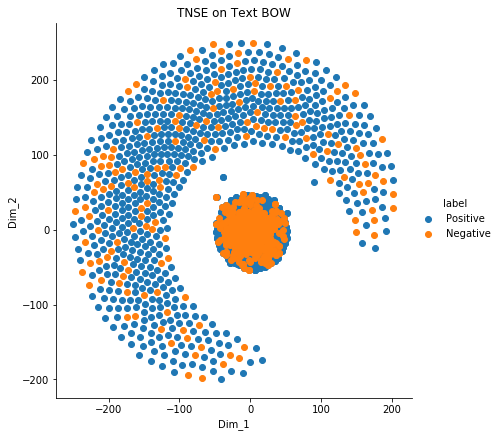

In [59]:
#Model
model = TSNE(n_components = 2,random_state= 0 , perplexity= 50 ,n_iter=5000)
#Configure TSNE
#No of componets - 2
#Default perflexity - 30
#Default learning rate - 200
#Maximum no of iteration - 1000
tsne_data = model.fit_transform(BOW_standardized_data)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data = tsne_data , columns = ('Dim_1','Dim_2','label'))

# Ploting the result of tsne
sb.FacetGrid(tsne_df,hue = 'label',size = 6).map(plt.scatter, 'Dim_1','Dim_2').add_legend()
plt.title('TNSE on Text BOW')
plt.show()

#### Observation(s):
1. At least 90% of the data is overlapped.
2. we are unable to simply draw a hyperplane and separate pasitive and negative reviews because it overlap each other. 

## Bi-Grams and n-Grams.

In [60]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
count_vect = CountVectorizer(ngram_range=(1,2),min_df=10,max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams",final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer (4986, 3144)
the number of unique words including both unigrams and bigrams 3144


## TF-IDF

In [61]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df =10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[:10])
print('='*50)
final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## Applying TNSE on Text TFIDF vectors

In [62]:
# Data-preprocessing: Standardizing the data
# from sklearn.preprocessing import StandardScaler 
tf_idf_std_data = StandardScaler(with_mean = False).fit_transform(final_tf_idf)
print(tf_idf_std_data.shape)
# convert sparse to dense as tsne takes dense vector
tf_idf_std_data = tf_idf_std_data.todense()
print(type(tf_idf_std_data))

(4986, 3144)
<class 'numpy.matrix'>


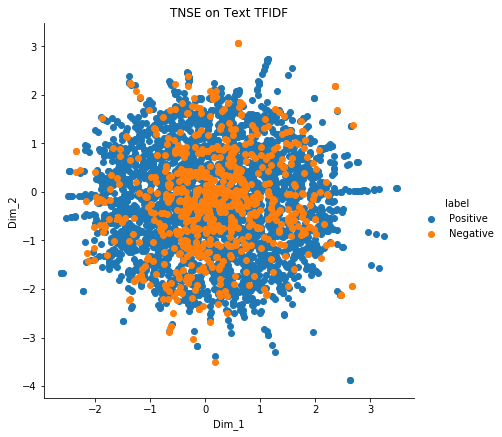

In [63]:
model = TSNE(n_components = 2,random_state= 0 , perplexity= 50 ,n_iter=5000)
tsne_data = model.fit_transform(tf_idf_std_data)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data = tsne_data , columns = ('Dim_1','Dim_2','label'))

# Ploting the result of tsne
sb.FacetGrid(tsne_df,hue = 'label',size = 6).map(plt.scatter, 'Dim_1','Dim_2').add_legend()
plt.title('TNSE on Text TFIDF')
plt.show()

#### Observation(s):
1. At least 90% of the data is overlapped.
2. we are unable to simply draw a hyperplane and separate pasitive and negative reviews because it overlap each other. 

##  Word2Vec

In [64]:
# Train your own Word2Vec model using your own text corpus
i = 0
list_of_sentance = []
for sentance in preprocessed_reviews:
#     list_of_sentance.append(sentance)
    list_of_sentance.append(sentance.split())
# print((list_of_sentance))

In [65]:
# Using Google News Word2Vectors
is_your_ram_gt_16gb = False
want_to_use_google_w2v = True
want_to_train_w2v = True

# print(list_of_sentance)

if want_to_train_w2v:
   # min_count = 5 considers only words that occured atleast 5 times
    w2v_model = Word2Vec(list_of_sentance,min_count = 5 ,size = 50 ,workers = 4)
    print(type(w2v_model))
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    

elif want_to_use_google_w2v and is_your_ram_gt_16gb :
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary = True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")    



<class 'gensim.models.word2vec.Word2Vec'>
[('alternative', 0.9941328763961792), ('snack', 0.9936726093292236), ('regular', 0.9933136105537415), ('excellent', 0.9932251572608948), ('satisfying', 0.9922833442687988), ('chewy', 0.9921470284461975), ('especially', 0.9920903444290161), ('earl', 0.9920855760574341), ('absolutely', 0.9920355677604675), ('crisp', 0.9920077919960022)]
[('tomatoes', 0.9994714260101318), ('come', 0.9994643330574036), ('simply', 0.9994384050369263), ('gourmet', 0.9994294047355652), ('perhaps', 0.9993866086006165), ('choice', 0.9993788599967957), ('peanuts', 0.9993764758110046), ('wow', 0.9993703365325928), ('point', 0.999362587928772), ('yes', 0.9993584156036377)]


In [66]:
print(type(w2v_model))
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

<class 'gensim.models.word2vec.Word2Vec'>
number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## Converting text into vectors using wAvg W2V, TFIDF-W2V


####  Avg W2v

In [67]:
#average word2vec
#compute average word2 vec for each review
sent_vectors = [];
for sent in tqdm(list_of_sentance):
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words = 0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec  /=cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))        



100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:09<00:00, 532.00it/s]


4986
50


## Applying TNSE on Text Avg W2V vectors

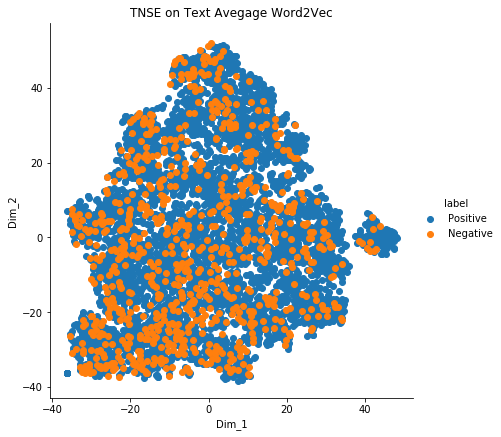

In [68]:
#TSNE
model = TSNE(n_components = 2,random_state= 0 , perplexity= 100 ,n_iter=10000)
tsne_data = model.fit_transform(sent_vectors)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data = tsne_data , columns = ('Dim_1','Dim_2','label'))

# Ploting the result of tsne
sb.FacetGrid(tsne_df,hue = 'label',size = 6).map(plt.scatter, 'Dim_1','Dim_2').add_legend()
plt.title('TNSE on Text Avegage Word2Vec')
plt.show()

# print('Completed')


#### Observation(s):

positive and negative reviews are not well seperated this also looks like bow and tfidf vector representations.

####  TFIDF weighted W2v

In [69]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(),list(model.idf_)))


In [70]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names()

# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = [] ; # the tfidf-w2v for each sentence/review is stored in this list
row = 0
for sent in tqdm(list_of_sentance):
    sent_vec = np.zeros(50)
    weight_sum = 0; # as word vectors are of zero length
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1


100%|██████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:56<00:00, 88.16it/s]


## Applying TNSE on Text TFIDF weighted Word2Vec vectors

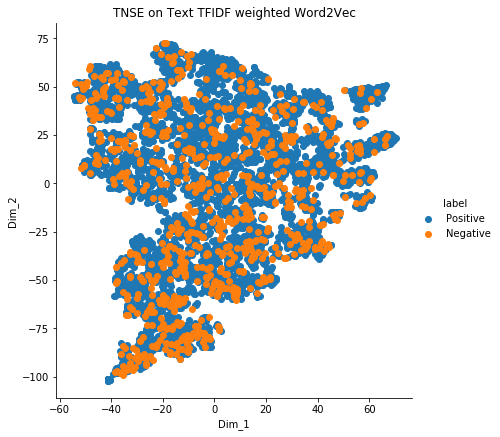

In [71]:
#TSNE

from sklearn.manifold import TSNE

# print(labels)

model = TSNE(n_components = 2,random_state= 0 , perplexity= 50 ,n_iter=5000)
#Configure TSNE
#No of componets - 2
#Default perflexity - 30
#Default learning rate - 200
#Maximum no of iteration - 1000
tsne_data = model.fit_transform(tfidf_sent_vectors)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data = tsne_data , columns = ('Dim_1','Dim_2','label'))

# Ploting the result of tsne
sb.FacetGrid(tsne_df,hue = 'label',size = 6).map(plt.scatter, 'Dim_1','Dim_2').add_legend()
plt.title('TNSE on Text TFIDF weighted Word2Vec')
plt.show()

# print('Completed')


#### Observation(s):

positive and negative reviwes are not well seperated they overlapped each other.

#### Conclusions:

1. By looking at all tsne reprentation, none of these gives well separated positive and negative reviews.
2. As none of TSNE representation gives a well separated both positive and negative reviews.
3. We can not simply draw a plane to separate positive and negative reviews. Although, By looking at only visual representation of data we can not take decision whether to draw a plane or not.
4. We will have some alternative method by that we will look at into this problem like how we can separate positive and negative reviews.